# Introduction

This notebook contains an analysis of the simulation `Brownian_2_cages`. Two species were separated and trapped in two different corrals (circular cage of radius 10 $\mu$m). The diffusion coefficient for the first species is $D = 0.1$ $\mu$m$^2/$s. For the second species, $D = 0.5$ $\mu$m$^2/$s. The exact coordinates for each particle in this simulation are stored in the file `real_coordinates.txt` and will be processed. A movie of the experiment is also created in order to perform SPT. The resulting trajectories are stored in the file `tracks.csv` and processed too. 

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.functions import TE_MSD,Michalet,set_size,pool_data
from sklearn.cluster import KMeans
import matplotlib as mpl
import seaborn as sns
import random

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=10
maxframe=100000
rsquared_threshold=-100

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [2]:
#Preprocess the Smoldyn exact trajectories
data = pd.read_csv('Brownian_cages/output.txt', sep=" ", header=None)
data.columns = ["iteration", "useless1", "useless2", "POSITION_X","POSITION_Y","TRACK_ID"]
data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Brownian_cages/temp.csv',index=None)

In [3]:
files = ["Brownian_cages/temp.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=4,display_id=True)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -100
Fit option:  4
Reading filenames in  ['Brownian_cages/temp.csv'] ...
Analysis for Brownian_cages/temp.csv ...
Track 0 out of 200
Track 1 out of 200
Track 2 out of 200
Track 3 out of 200
Track 4 out of 200
Track 5 out of 200
Track 6 out of 200
Track 7 out of 200
Track 8 out of 200
Track 9 out of 200
Track 10 out of 200
Track 11 out of 200
Track 12 out of 200
Track 13 out of 200
Track 14 out of 200
Track 15 out of 200
Track 16 out of 200
Track 17 out of 200
Track 18 out of 200
Track 19 out of 200
Track 20 out of 200
Track 21 out of 200
Track 22 out of 200
Track 23 out of 200
Track 24 out of 200
Track 25 out of 200
Track 26 out of 200
Track 27 out of 200
Track 28 out of 200
Track 29 out of 200
Track 30 out of 200
Track 31 out of 200
Track 32 out of 200
Track 33 out of 200
Track 34 out of 200
Track 35 out of 200
Track 36 out of 200
Track 37 out of 200
Track 38 out of 200


We can immediately recover the real label for each track from the spatial position of each track (whether its in corral 1 or 2). 

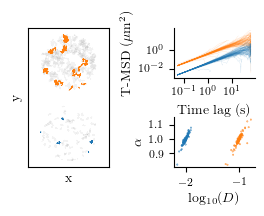

In [4]:
Y = list(df['y'].values)
X = list(df['x'].values)
label = np.zeros(len(Y))
for k in range(len(Y)):
    y = Y[k]
    if y[0] < 50:
        label[k] = 0
    else:
        label[k] = 1

c1 = 'tab:orange'
c2 = 'tab:blue'

#Create RGB array for trajectory plot
label_rgb = [c1 if x==1 else c2 for x in label]
df['Real_Label'] = label

#Generate LaTex-compatible plot
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(15))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = label_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    

trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=label_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=label_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Brownian_cages/Plots/brown_cages_exact_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
MSDfast = list(df['MSD'][(df['Real_Label']==1)].values)
MSDslow = list(df['MSD'][(df['Real_Label']==0)].values)
#Michalet(MSDfast,cutoff=1) #CAREFUL THIS IS SLOW DUE TO THE VERY LONG TRACKS

# Calibrate the Gaussian mixture

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=2000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=200)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

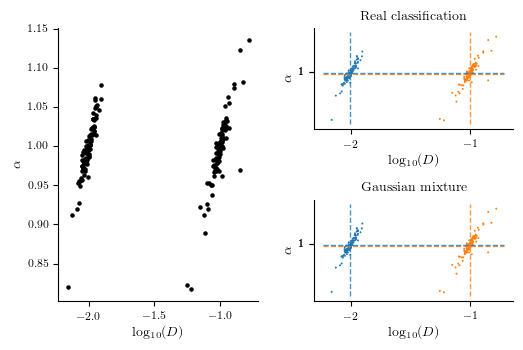

In [7]:
mpl.rcParams.update(mpl.rcParamsDefault)

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==1 else c2 for x in label]
        
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(2, 4, wspace=0.8, hspace=0.7,bottom=0.2,left=0.2)
ax0 = fig.add_subplot(grid[0:2, 0:2])
ax1 = fig.add_subplot(grid[0, 2:4])
ax2 = fig.add_subplot(grid[1, 2:4])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=label_rgb,s=2,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['Real_Label']==1)].mean()
meanalpha0 = df['alpha'][(df['Real_Label']==0)].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['Real_Label']==1)].mean()
meanD0 = df['D'][(df['Real_Label']==0)].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Real classification',fontsize=10)

ax2.scatter(D,alpha,c=labels_GM_rgb,s=2,edgecolors='w',linewidths=0.001)
ax2.set_xlabel(r'log$_{10}(D)$')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

xmin, xmax = ax2.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==0)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==1)].mean()
ax2.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax2.get_ylim()
meanD1 = df['D'][(df['GM_Label']==0)].mean()
meanD0 = df['D'][(df['GM_Label']==1)].mean()
ax2.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_xticks([round(meanD1,2),round(meanD0,2)])
ax2.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Brownian_cages/Plots/brown_cages_exact_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Test number of fitting points

In [8]:
D1value = []
D0value = []
D1sdv = []
D0sdv = []
alpha1value = []
alpha0value = []
alpha1sdv = []
alpha0sdv = []

for pts in [2,3,4,5,6,7,8,9,10]:
    print("Number of fitting pts = "+str(pts))
    data[["POSITION_X","POSITION_Y","TRACK_ID"]].to_csv('Brownian_cages/temp.csv',index=None)
    files = ["Brownian_cages/temp.csv"]
    df_exact = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=pts,display_id=False)

    Y = list(df_exact['y'].values)
    X = list(df_exact['x'].values)
    label = np.zeros(len(Y))
    for k in range(len(Y)):
        y = Y[k]
        if y[0] < 50:
            label[k] = 0
        else:
            label[k] = 1

    c1 = 'tab:orange'
    c2 = 'tab:blue'

    #Create RGB array for trajectory plot
    label_rgb = [c1 if x==1 else c2 for x in label]
    df_exact['Real_Label'] = label

    describe_array1 = df_exact[(df_exact['Real_Label']==1)].describe().to_numpy()
    d1 = describe_array1[1,1] 
    d1sdt = describe_array1[2,1]
    alpha1 = describe_array1[1,0]
    alpha1sdt = describe_array1[2,0]
    describe_array0 = df_exact[(df_exact['Real_Label']==0)].describe().to_numpy()
    d0 = describe_array0[1,1] 
    d0sdt = describe_array0[2,1]
    alpha0 = describe_array0[1,0]
    alpha0sdt = describe_array0[2,0]
    
    D1value.append(d1)
    D0value.append(d0)
    
    D1sdv.append(d1sdt)
    D0sdv.append(d0sdt)
    
    alpha1value.append(alpha1)
    alpha0value.append(alpha0)
    
    alpha1sdv.append(alpha1sdt)
    alpha0sdv.append(alpha0sdt)

Number of fitting pts = 2
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -100
Fit option:  2
Reading filenames in  ['Brownian_cages/temp.csv'] ...
Analysis for Brownian_cages/temp.csv ...
193  tracks were kept out of  197433 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Number of fitting pts = 3
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -100
Fit option:  3
Reading filenames in  ['Brownian_cages/temp.csv'] ...
Analysis for Brownian_cages/temp.csv ...
193  tracks were kept out of  197433 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Number of fitting pts = 4
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -100
Fit option:  4
Reading filenames in  ['Brownian_cages/temp.csv'] ...
Analysis for Brownian_cages/temp.csv ...
193  tra

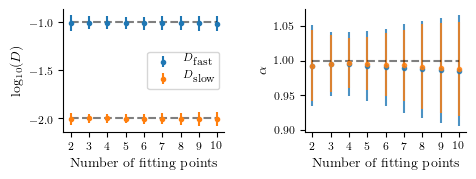

In [9]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')

width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.1,bottom=0.5)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])

ax1.errorbar([2,3,4,5,6,7,8,9,10],D1value,yerr=D1sdv,fmt='o',label=r'$D_{\textrm{fast}}$',markersize=3)
ax1.errorbar([2,3,4,5,6,7,8,9,10],D0value,yerr=D0sdv,fmt='o',label=r'$D_{\textrm{slow}}$',markersize=3)
ax1.hlines(-1.0,2,10,linestyles='dashed',alpha=0.5)
ax1.hlines(-2.0,2,10,linestyles='dashed',alpha=0.5)
ax1.set_xlabel('Number of fitting points')
ax1.set_ylabel(r'log$_{10}$($D$)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks([2,3,4,5,6,7,8,9,10])
ax1.legend()

ax2.errorbar([2,3,4,5,6,7,8,9,10],alpha1value,yerr=alpha1sdv,fmt='o',alpha=0.8,markersize=3)
ax2.errorbar([2,3,4,5,6,7,8,9,10],alpha0value,yerr=alpha0sdv,fmt='o',alpha=0.8,markersize=3)
ax2.hlines(1,2,10,linestyles='dashed',alpha=0.5)
ax2.set_xlabel('Number of fitting points')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks([2,3,4,5,6,7,8,9,10])

fig.savefig('Brownian_cages/Plots/brown_cages_exact_fit_options.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Simulated movie

In [10]:
minframe=12
files = ["Brownian_cages/movie/tracks.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[2,6])

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  12 , maxframe =  100000 , R2 threshold =  -100
Fit option:  [2, 6]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
3910  tracks were kept out of  177516 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


In [11]:
display(df.describe())
N = 3910
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,3910.000000,3.910000e+03,3910.000000,3910.000000,3910.000000
mean,0.649274,-1.384211e+00,0.147746,-0.725696,41.731969
std,0.357193,5.139320e-01,0.111496,4.929919,42.534693
min,0.100000,-3.498747e+00,0.000232,-96.782354,12.000000
25%,0.381739,-1.756917e+00,0.062534,-0.313373,17.000000
50%,0.642690,-1.312215e+00,0.123468,0.433359,27.000000
75%,0.897482,-1.004026e+00,0.206403,0.838130,48.000000
max,1.805737,-3.779682e-13,0.732872,0.999071,428.000000


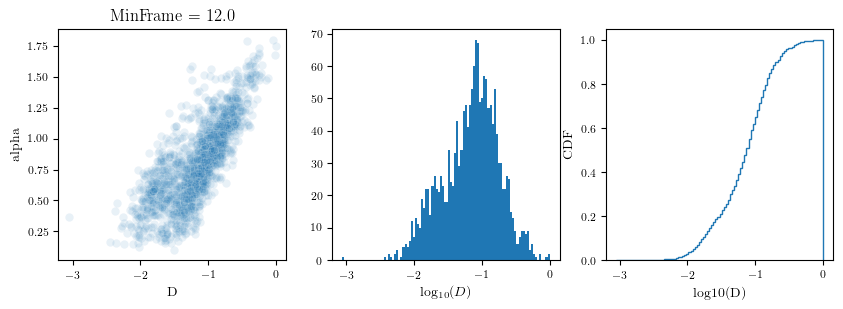

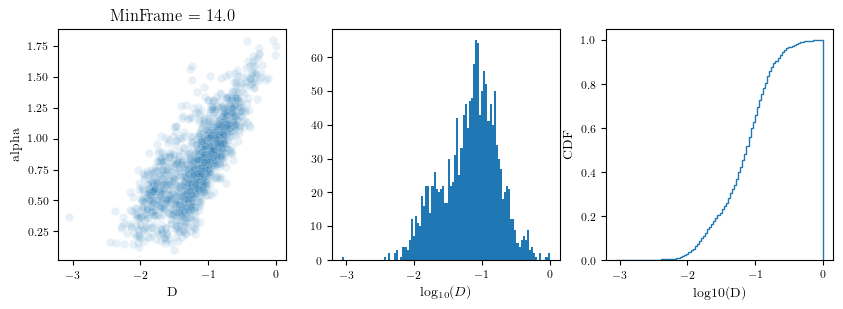

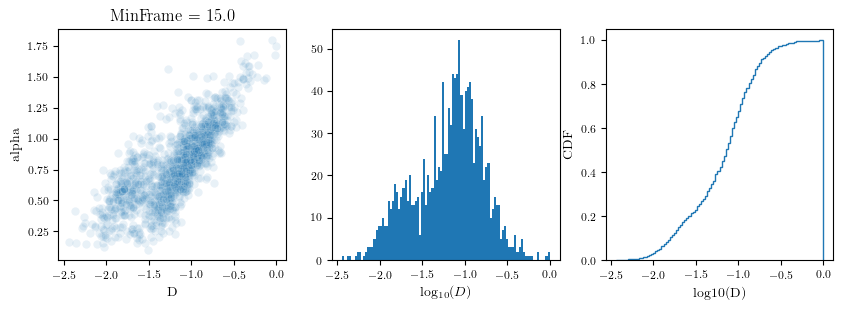

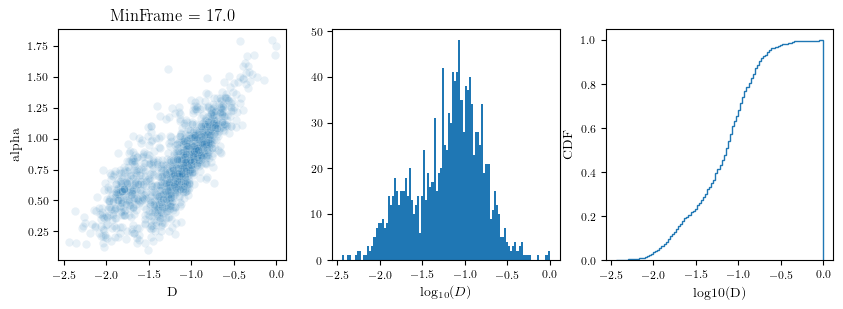

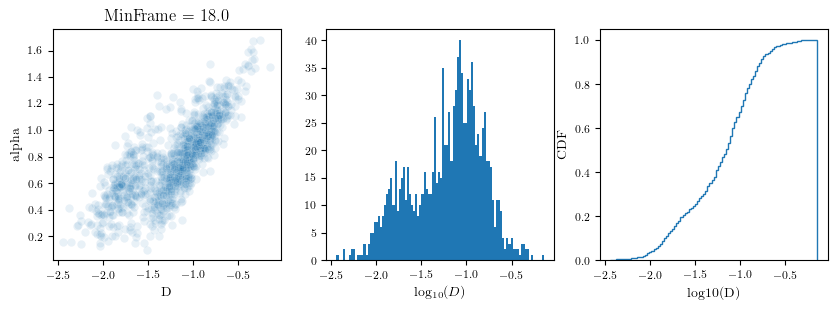

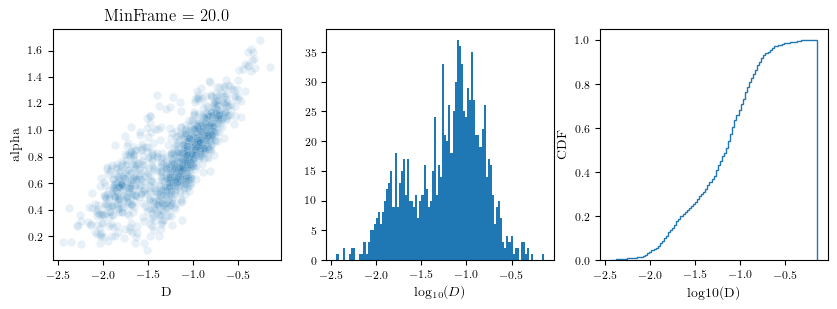

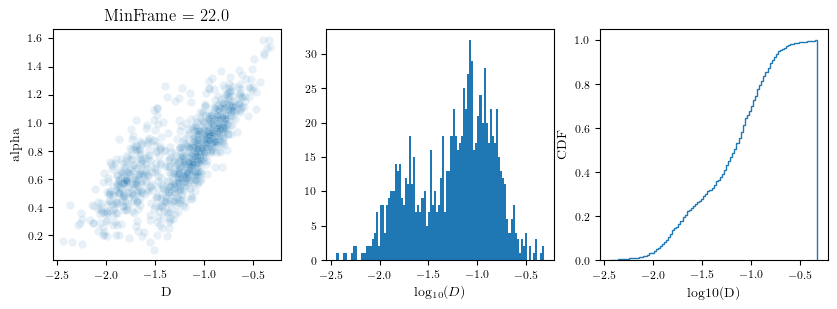

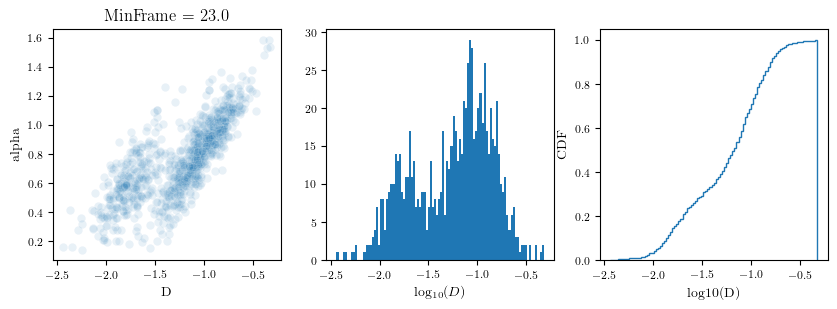

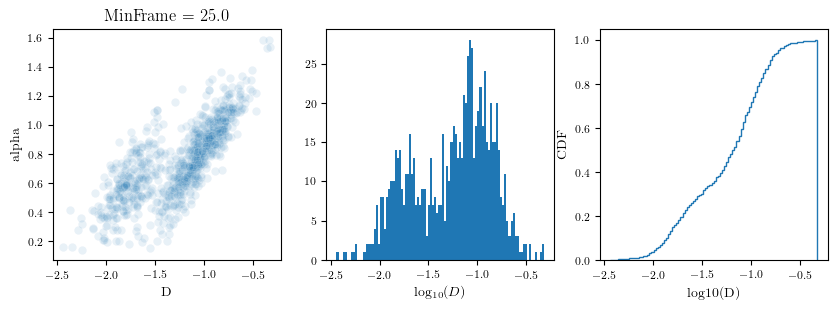

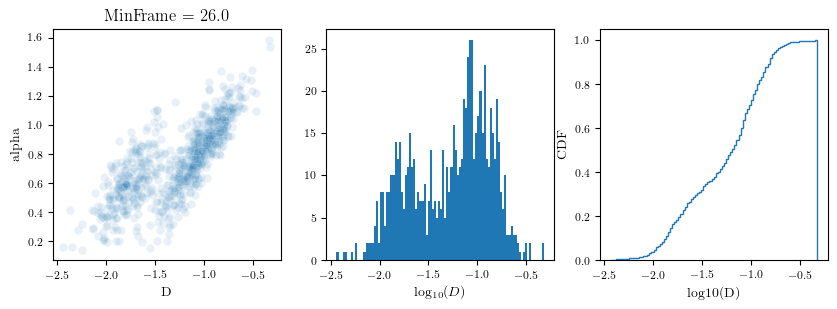

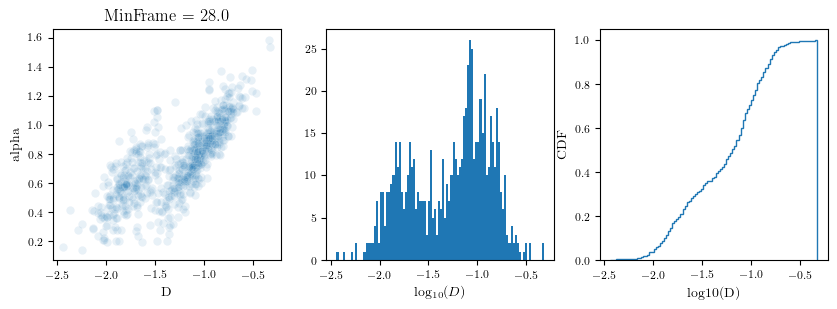

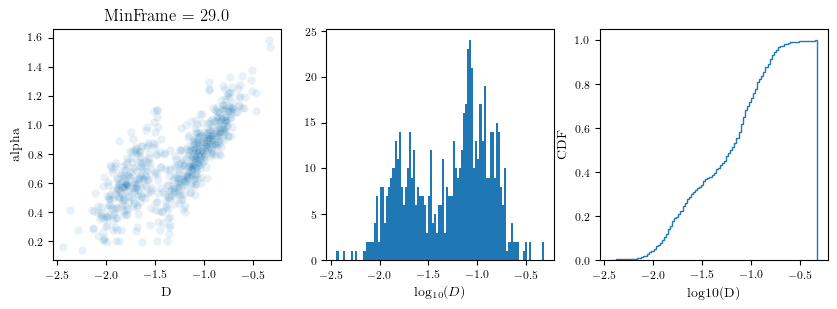

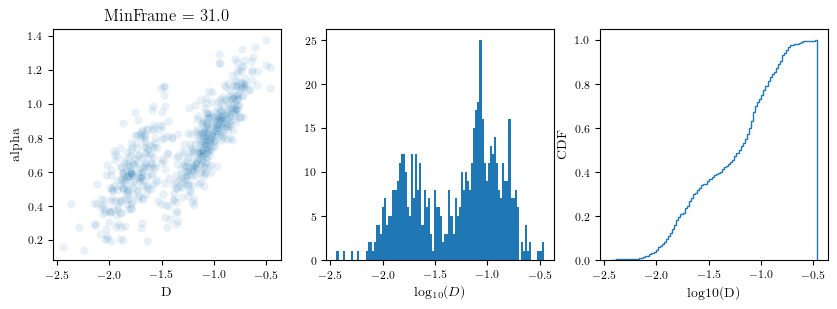

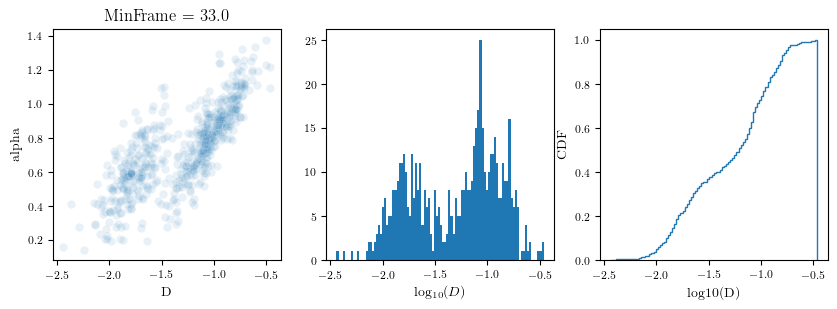

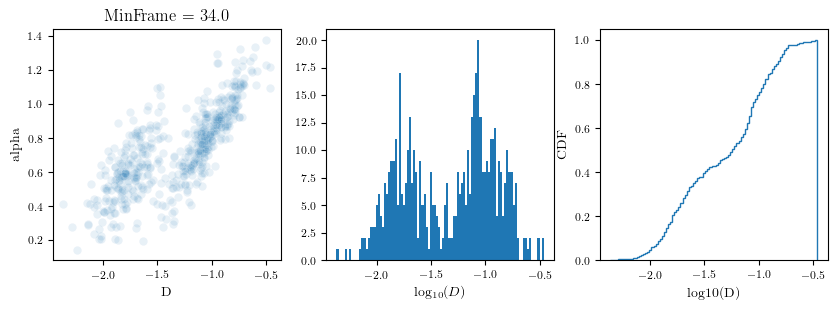

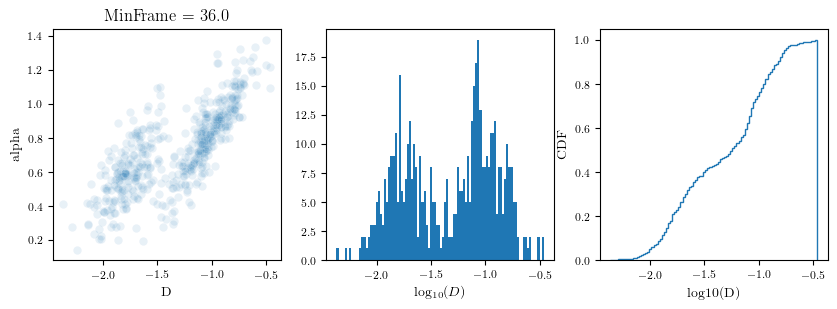

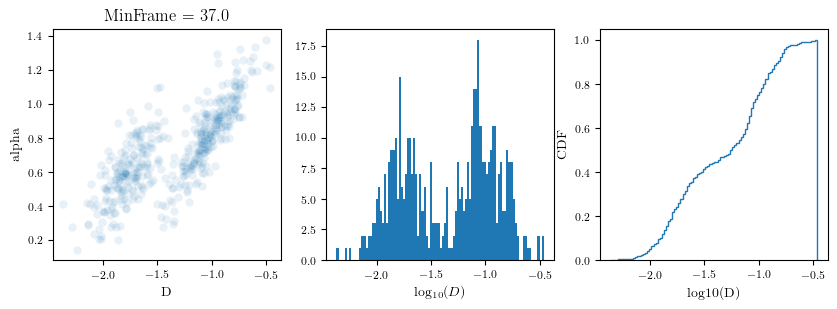

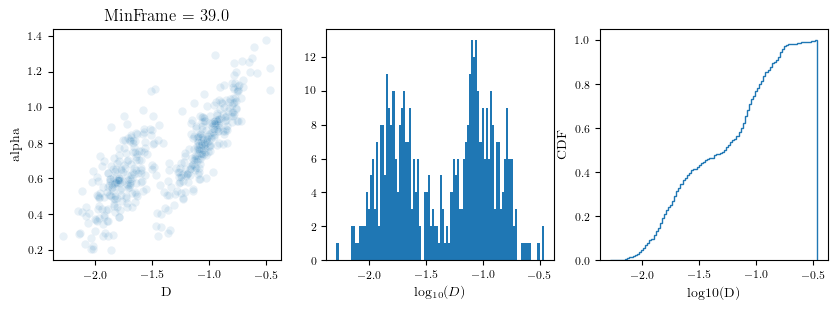

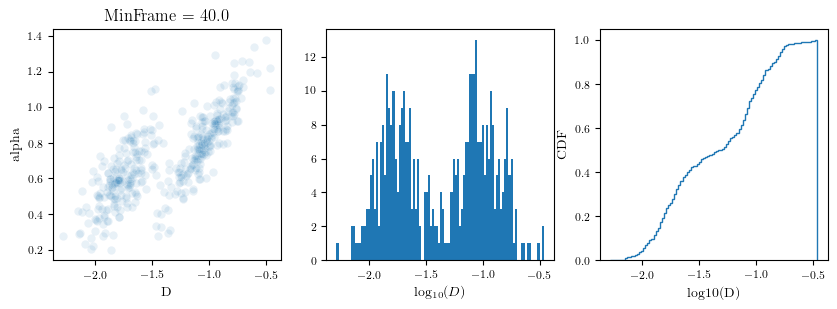

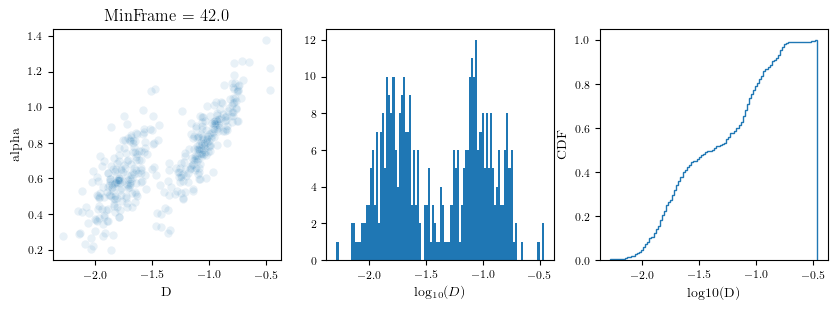

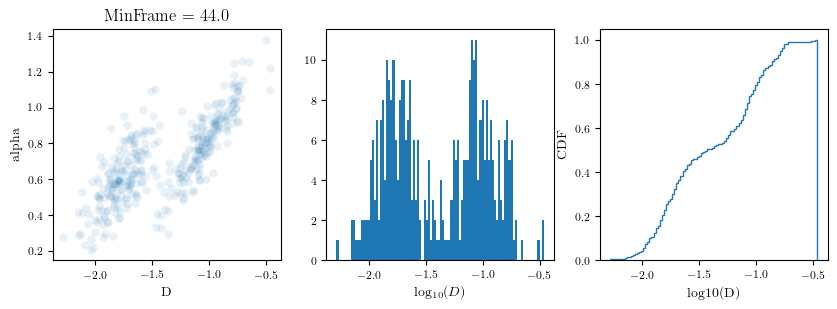

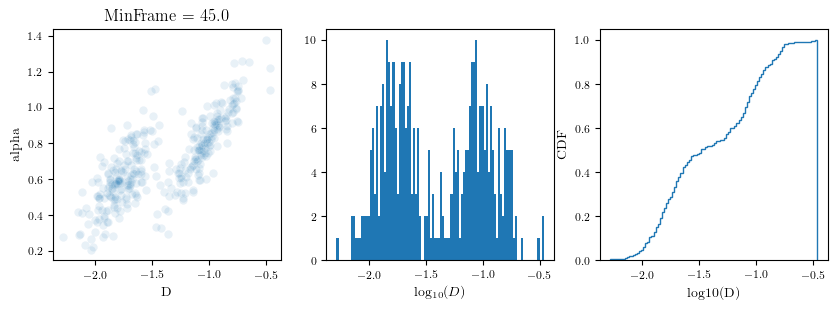

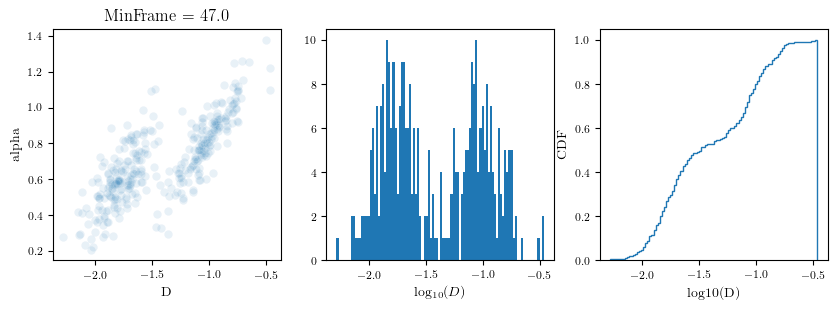

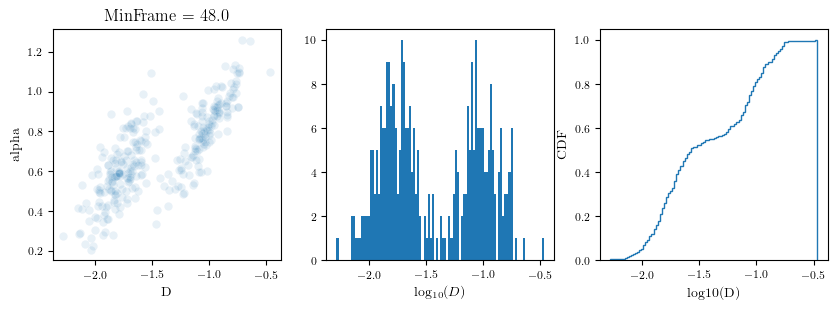

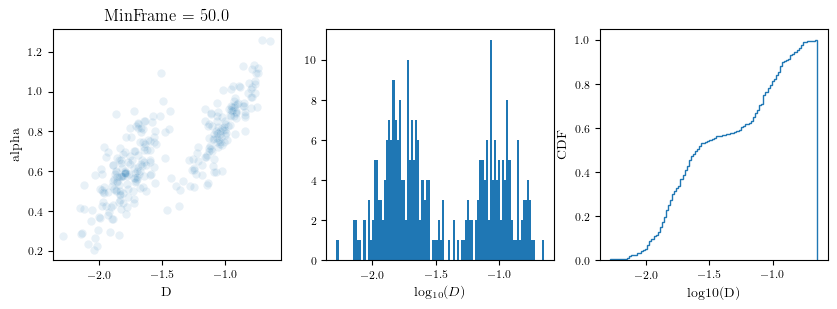

In [12]:
N = np.linspace(minframe,50,25)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>0.5)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


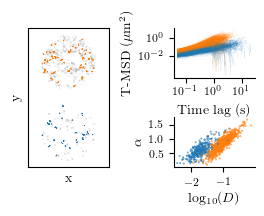

In [13]:
minframe = 20
r2 = 0.5
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

Y = list(df['y'].values)
X = list(df['x'].values)
label = np.zeros(len(Y))
for k in range(len(Y)):
    y = Y[k]
    if y[0] < 80:
        label[k] = 0
    else:
        label[k] = 1

c1 = 'tab:orange'
c2 = 'tab:blue'

#Create RGB array for trajectory plot
label_rgb = [c1 if x==1 else c2 for x in label]
df['Real_Label'] = label

#Generate LaTex-compatible plot
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(100))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = label_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    

trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=label_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=label_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('Brownian_cages/Plots/brown_cages_movie_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Calibrate the Gaussian mixture

In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=4000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=500)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


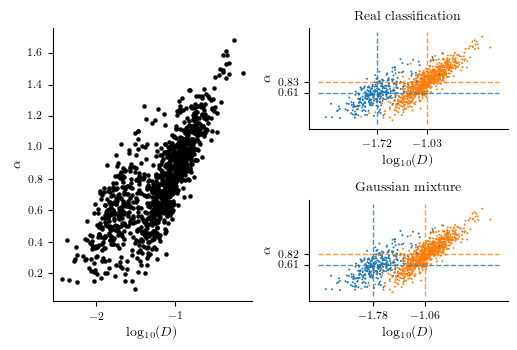

The total error is  93.32113449222324  % or  6.678865507776763 %


In [15]:
mpl.rcParams.update(mpl.rcParamsDefault)

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==1 else c2 for x in label]
        
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(2, 4, wspace=0.8, hspace=0.7,bottom=0.2,left=0.2)
ax0 = fig.add_subplot(grid[0:2, 0:2])
ax1 = fig.add_subplot(grid[0, 2:4])
ax2 = fig.add_subplot(grid[1, 2:4])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=label_rgb,s=2,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['Real_Label']==1)].mean()
meanalpha0 = df['alpha'][(df['Real_Label']==0)].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['Real_Label']==1)].mean()
meanD0 = df['D'][(df['Real_Label']==0)].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Real classification',fontsize=10)

ax2.scatter(D,alpha,c=labels_GM_rgb,s=2,edgecolors='w',linewidths=0.001)
ax2.set_xlabel(r'log$_{10}(D)$')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

xmin, xmax = ax2.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==0)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==1)].mean()
ax2.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax2.get_ylim()
meanD1 = df['D'][(df['GM_Label']==0)].mean()
meanD0 = df['D'][(df['GM_Label']==1)].mean()
ax2.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax2.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax2.set_xticks([round(meanD1,2),round(meanD0,2)])
ax2.set_title('Gaussian mixture',fontsize=10)

fig.savefig('Brownian_cages/Plots/brown_cages_movie_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

error = []
for lab1,lab2 in zip(label,labels_GM):
    if lab1==lab2:
        error.append(0)
    else:
        error.append(1)
total_error = sum(error)
print("The total error is ",total_error*100/len(error)," % or ",100-total_error*100/len(error),'%')
    

# Visualize TE-MSD before analysis of fit parameters

Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.
Compute the TE-MSD and ensemble variance...
Done. The TE-MSD and associated variance have been generated.


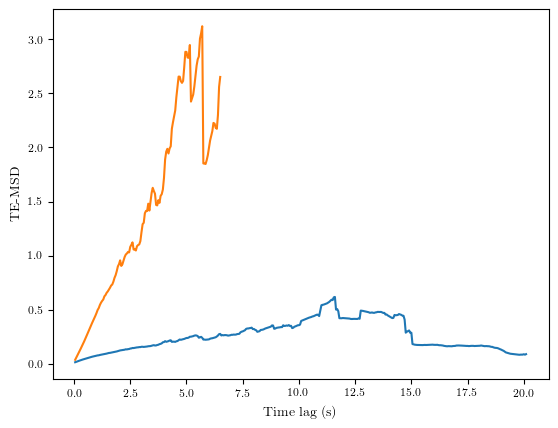

In [16]:
MSDfast = list(df['MSD'][(df['GM_Label']==1)].values)
MSDslow = list(df['MSD'][(df['GM_Label']==0)].values)
msdf,mvarf,timelagf = TE_MSD(MSDfast,plot=False)
msds,mvars,timelags = TE_MSD(MSDslow,plot=False)
plt.plot(timelagf,msdf)
plt.plot(timelags,msds)
plt.ylabel('TE-MSD')
plt.xlabel('Time lag (s)')
plt.show()

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  847
Number of T-MSDs at time lag  0.1  =  847
Number of T-MSDs at time lag  0.15  =  847
Number of T-MSDs at time lag  0.2  =  847
Number of T-MSDs at time lag  0.25  =  847
Number of T-MSDs at time lag  0.3  =  847
Number of T-MSDs at time lag  0.35  =  847
Number of T-MSDs at time lag  0.4  =  847
Number of T-MSDs at time lag  0.45  =  847
Number of T-MSDs at time lag  0.5  =  847
Number of T-MSDs at time lag  0.55  =  847
Number of T-MSDs at time lag  0.6  =  847
Number of T-MSDs at time lag  0.65  =  847
Number of T-MSDs at time lag  0.7  =  847
Number of T-MSDs at time lag  0.75  =  847
Number of T-MSDs at time lag  0.8  =  847
Number of T-MSDs at time lag  0.85  =  847
Number of T-MSDs at time lag  0.9  =  847
Number of T-MSDs at time lag  0.95  =  847
Number of 

Build intermediary series of matrices cut to  1  s...
Compute the ensemble average of the covariance matrices...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of fitting points has been computed.
The relative error on the slope is minimum for P =  4 fitting points.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of fitting points has been computed.
The relative error on the slope is minimum for P =  4 fitting points.
D =  0.1026  +-  0.0442
The error on the intercept is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squa

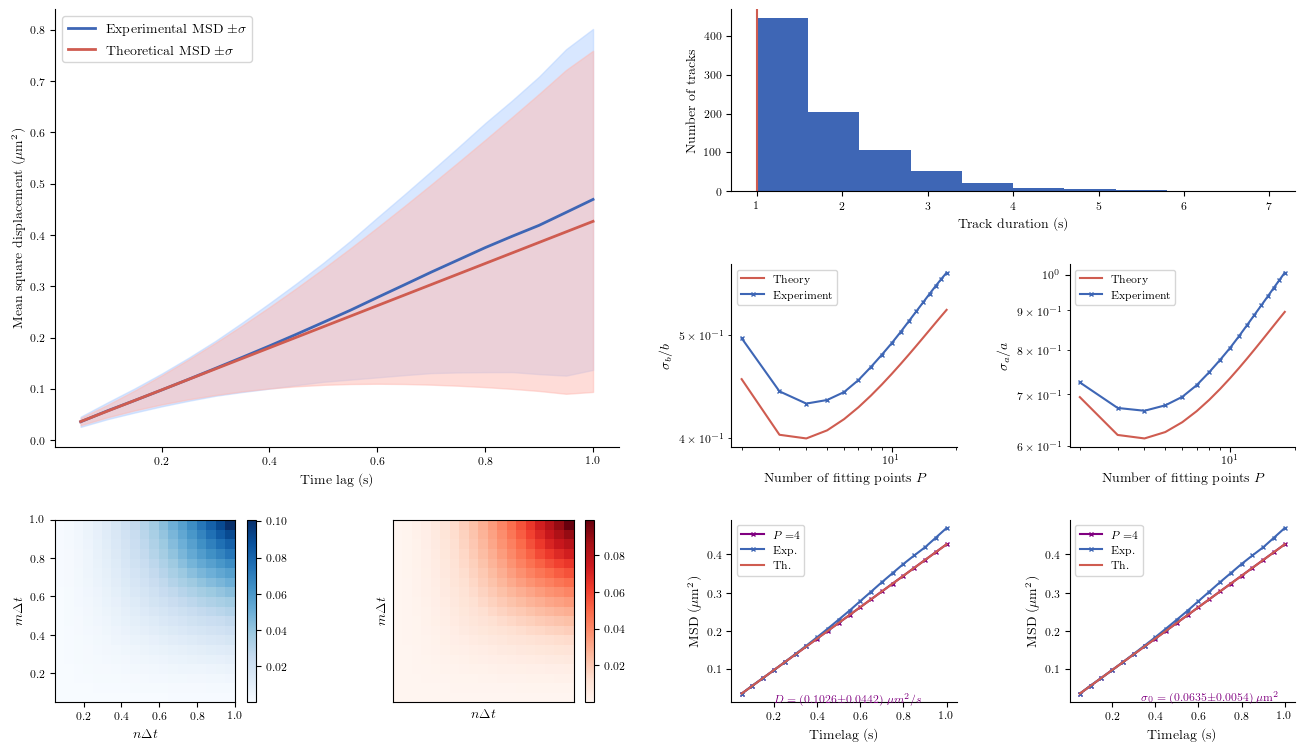

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1013: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


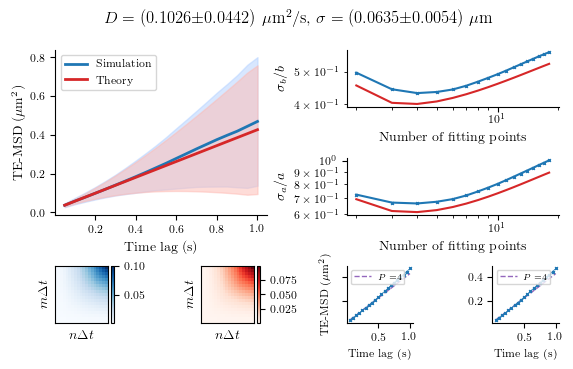

In [17]:
MSD1 = df['MSD'][(df['GM_Label']==0)]
Michalet(MSD1,cutoff=1)
plt.savefig('Brownian_cages/Plots/michalet_group1.pdf')
plt.show()

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  246
Number of T-MSDs at time lag  0.1  =  246
Number of T-MSDs at time lag  0.15  =  246
Number of T-MSDs at time lag  0.2  =  246
Number of T-MSDs at time lag  0.25  =  246
Number of T-MSDs at time lag  0.3  =  246
Number of T-MSDs at time lag  0.35  =  246
Number of T-MSDs at time lag  0.4  =  246
Number of T-MSDs at time lag  0.45  =  246
Number of T-MSDs at time lag  0.5  =  246
Number of T-MSDs at time lag  0.55  =  246
Number of T-MSDs at time lag  0.6  =  246
Number of T-MSDs at time lag  0.65  =  246
Number of T-MSDs at time lag  0.7  =  246
Number of T-MSDs at time lag  0.75  =  246
Number of T-MSDs at time lag  0.8  =  246
Number of T-MSDs at time lag  0.85  =  246
Number of T-MSDs at time lag  0.9  =  246
Number of T-MSDs at time lag  0.95  =  246
Number of 

Number of T-MSDs at time lag  17.1  =  2
Number of T-MSDs at time lag  17.15  =  2
Number of T-MSDs at time lag  17.2  =  2
Number of T-MSDs at time lag  17.25  =  2
Number of T-MSDs at time lag  17.3  =  2
Number of T-MSDs at time lag  17.35  =  2
Number of T-MSDs at time lag  17.4  =  2
Number of T-MSDs at time lag  17.45  =  2
Number of T-MSDs at time lag  17.5  =  2
Number of T-MSDs at time lag  17.55  =  2
Number of T-MSDs at time lag  17.6  =  2
Number of T-MSDs at time lag  17.65  =  2
Number of T-MSDs at time lag  17.7  =  2
Number of T-MSDs at time lag  17.75  =  2
Number of T-MSDs at time lag  17.8  =  2
Number of T-MSDs at time lag  17.85  =  2
Number of T-MSDs at time lag  17.9  =  2
Number of T-MSDs at time lag  17.95  =  2
Number of T-MSDs at time lag  18.0  =  2
Number of T-MSDs at time lag  18.05  =  2
Number of T-MSDs at time lag  18.1  =  2
Number of T-MSDs at time lag  18.15  =  2
Number of T-MSDs at time lag  18.2  =  2
Number of T-MSDs at time lag  18.25  =  2
Numb

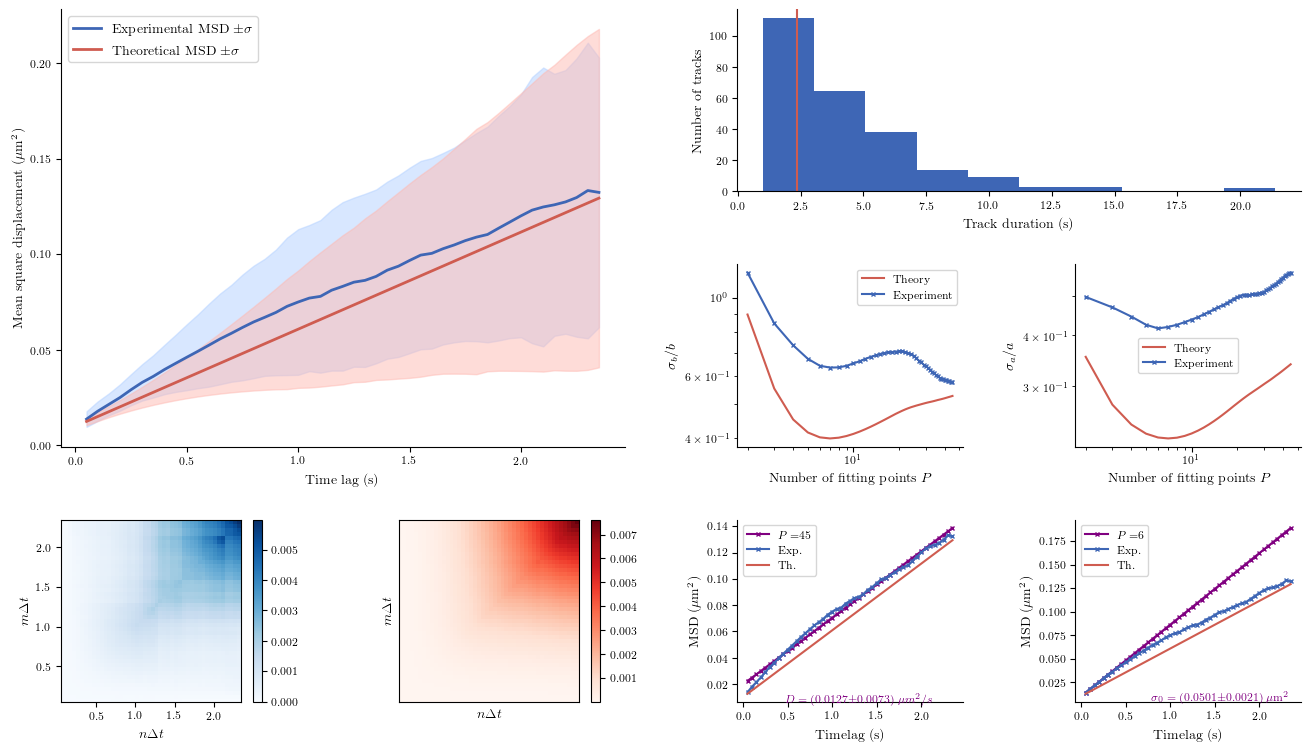

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1013: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [18]:
MSD2 = df['MSD'][(df['GM_Label']==1)]
Michalet(MSD2,cutoff=2.35)
plt.savefig('Brownian_cages/Plots/michalet_group2.pdf')

# Test number of fitting points

In [19]:
D1value = []
D0value = []
D1sdv = []
D0sdv = []
alpha1value = []
alpha0value = []
alpha1sdv = []
alpha0sdv = []

for pts in [3,4,5,6,7,8,9,10,11]:
    files = ["Brownian_cages/movie/tracks.csv"]
    df = pool_data(files,dt,15,maxframe,0.5,fit_option=[1,pts],display_id=False)

    Y = list(df['y'].values)
    X = list(df['x'].values)
    label = np.zeros(len(Y))
    for k in range(len(Y)):
        y = Y[k]
        if y[0] < 80:
            label[k] = 0
        else:
            label[k] = 1

    c1 = 'tab:orange'
    c2 = 'tab:blue'

    #Create RGB array for trajectory plot
    label_rgb = [c1 if x==1 else c2 for x in label]
    df['Real_Label'] = label

    describe_array1 = df[(df['Real_Label']==1)].describe().to_numpy()
    d1 = describe_array1[1,1] 
    d1sdt = describe_array1[2,1]
    alpha1 = describe_array1[1,0]
    alpha1sdt = describe_array1[2,0]
    describe_array0 = df[(df['Real_Label']==0)].describe().to_numpy()
    d0 = describe_array0[1,1] 
    d0sdt = describe_array0[2,1]
    alpha0 = describe_array0[1,0]
    alpha0sdt = describe_array0[2,0]
    
    D1value.append(d1)
    D0value.append(d0)
    
    D1sdv.append(d1sdt)
    D0sdv.append(d0sdt)
    
    alpha1value.append(alpha1)
    alpha0value.append(alpha0)
    
    alpha1sdv.append(alpha1sdt)
    alpha0sdv.append(alpha0sdt)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [1, 3]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
930  tracks were kept out of  177516 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [1, 4]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
1168  tracks were kept out of  177516 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [1, 5]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
1336  tracks were kept ou

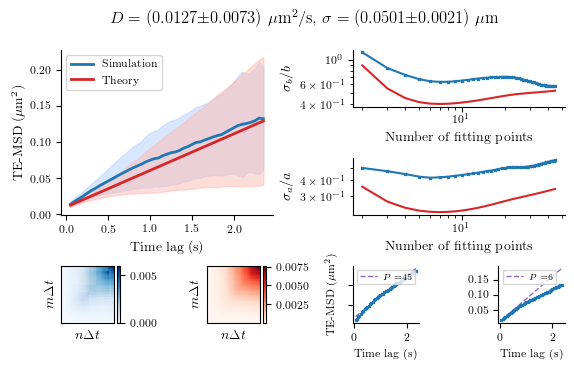

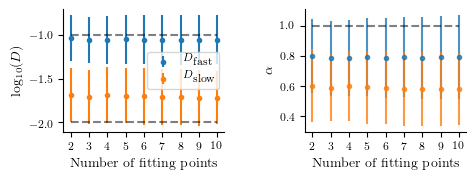

In [20]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')

width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.1,bottom=0.5)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])

ax1.errorbar([2,3,4,5,6,7,8,9,10],D1value,yerr=D1sdv,fmt='o',label=r'$D_{\textrm{fast}}$',markersize=3)
ax1.errorbar([2,3,4,5,6,7,8,9,10],D0value,yerr=D0sdv,fmt='o',label=r'$D_{\textrm{slow}}$',markersize=3)
ax1.hlines(-1.0,2,10,linestyles='dashed',alpha=0.5)
ax1.hlines(-2.0,2,10,linestyles='dashed',alpha=0.5)
ax1.set_xlabel('Number of fitting points')
ax1.set_ylabel(r'log$_{10}$($D$)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks([2,3,4,5,6,7,8,9,10])
ax1.legend()

ax2.errorbar([2,3,4,5,6,7,8,9,10],alpha1value,yerr=alpha1sdv,fmt='o',alpha=0.8,markersize=3)
ax2.errorbar([2,3,4,5,6,7,8,9,10],alpha0value,yerr=alpha0sdv,fmt='o',alpha=0.8,markersize=3)
ax2.hlines(1,2,10,linestyles='dashed',alpha=0.5)
ax2.set_xlabel('Number of fitting points')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks([2,3,4,5,6,7,8,9,10])

fig.savefig('Brownian_cages/Plots/brown_cages_movie_fit_options.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Different version where the number of fit points is set and we shift the first fit point

In [21]:
npoints = 4

D1value = []
D0value = []
D1sdv = []
D0sdv = []
alpha1value = []
alpha0value = []
alpha1sdv = []
alpha0sdv = []

for pts in [0,1,2,3,4,5,6,7,8]:
    files = ["Brownian_cages/movie/tracks.csv"]
    df = pool_data(files,dt,15,maxframe,0.5,fit_option=[pts,pts+npoints],display_id=False)

    Y = list(df['y'].values)
    X = list(df['x'].values)
    label = np.zeros(len(Y))
    for k in range(len(Y)):
        y = Y[k]
        if y[0] < 80:
            label[k] = 0
        else:
            label[k] = 1

    c1 = 'tab:orange'
    c2 = 'tab:blue'

    #Create RGB array for trajectory plot
    label_rgb = [c1 if x==1 else c2 for x in label]
    df['Real_Label'] = label

    describe_array1 = df[(df['Real_Label']==1)].describe().to_numpy()
    d1 = describe_array1[1,1] 
    d1sdt = describe_array1[2,1]
    alpha1 = describe_array1[1,0]
    alpha1sdt = describe_array1[2,0]
    describe_array0 = df[(df['Real_Label']==0)].describe().to_numpy()
    d0 = describe_array0[1,1] 
    d0sdt = describe_array0[2,1]
    alpha0 = describe_array0[1,0]
    alpha0sdt = describe_array0[2,0]
    
    D1value.append(d1)
    D0value.append(d0)
    
    D1sdv.append(d1sdt)
    D0sdv.append(d0sdt)
    
    alpha1value.append(alpha1)
    alpha0value.append(alpha0)
    
    alpha1sdv.append(alpha1sdt)
    alpha0sdv.append(alpha0sdt)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [0, 4]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
1200  tracks were kept out of  177516 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [1, 5]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
1336  tracks were kept out of  177516 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.
Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  15 , maxframe =  100000 , R2 threshold =  0.5
Fit option:  [2, 6]
Reading filenames in  ['Brownian_cages/movie/tracks.csv'] ...
Analysis for Brownian_cages/movie/tracks.csv ...
1497  tracks were kept o

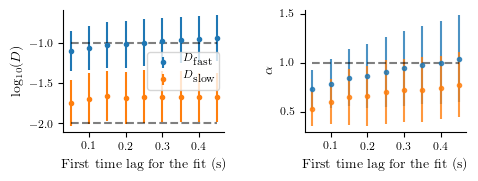

In [22]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')

width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.8))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.1,bottom=0.5)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])

ax1.errorbar([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],D1value,yerr=D1sdv,fmt='o',label=r'$D_{\textrm{fast}}$',markersize=3)
ax1.errorbar([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],D0value,yerr=D0sdv,fmt='o',label=r'$D_{\textrm{slow}}$',markersize=3)
ax1.hlines(-1.0,0.05,0.45,linestyles='dashed',alpha=0.5)
ax1.hlines(-2.0,0.05,0.45,linestyles='dashed',alpha=0.5)
ax1.set_xlabel('First time lag for the fit (s)')
ax1.set_ylabel(r'log$_{10}$($D$)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks([0.1,0.2,0.3,0.4])
ax1.legend()

ax2.errorbar([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],alpha1value,yerr=alpha1sdv,fmt='o',alpha=0.8,markersize=3)
ax2.errorbar([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],alpha0value,yerr=alpha0sdv,fmt='o',alpha=0.8,markersize=3)
ax2.hlines(1,0.05,0.45,linestyles='dashed',alpha=0.5)
ax2.set_xlabel('First time lag for the fit (s)')
ax2.set_ylabel(r'$\alpha$')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks([0.1,0.2,0.3,0.4])

fig.savefig('Brownian_cages/Plots/brown_cages_movie_first_point_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()